In [1]:
# pytorch and fastai
from fastai import *
from fastai.vision import *
from fastai.metrics import accuracy
from sklearn.datasets import fetch_mldata
from sklearn.model_selection import train_test_split

pd.set_option('display.max_colwidth', -1)

import os; os.chdir("/home/athon/thesis/notebooks")
from tools.config   import TCGA_MUT,GENE2VEC,FIGURES
from tools.somatic  import process_labels,filter_variants,filter_genes, \
                           visualise_distributions, dedup, reshape_pivot, \
                           convert_to_onehot, get_label_df
os.chdir("/home/athon/thesis/notebooks/1_distributed_genes")

In [2]:
def freememory():
    """
    Run garbage collection to free up memory.
    """
    import gc
    gc.collect()

def freegpu(data, model):
    del data
    del model
    freememory()
    torch.cuda.empty_cache()
    freememory()

In [28]:
def train_stage1(data_dir, name, arch=models.resnet34, cycles=10, bs=32):
    data = (ImageList.from_folder(data_dir + '/')
            .split_by_folder(train='train', valid='valid')
            .label_from_folder()
            .databunch(bs=bs)
            .normalize(imagenet_stats)
           )    
    
    learn = cnn_learner(data, arch, metrics=[accuracy], callback_fns=ShowGraph)
    learn.fit_one_cycle(cycles,1e-3)
    learn.save('ONCO128_'.format(name))
    
    preds,y = learn.get_preds()
    top1 = accuracy(preds,y)
    top5 = top_k_accuracy(preds,y,5)
    print('stage1 acc: {}, top5: {}'.format(top1,top5))
    
    # Free up gpu and memory
    freegpu(data, learn)
    return top1,top5

def train_data(archs, cycles=1):
    data_dir = "../../data/gene_images/2d_clustering/ONCO_DIM_128"
    results = {'model':[],'dataset':[],'top1':[],'top5':[]}
    # iterate architectures
    for name, arch in archs:     
        # iterate models
        dim_ = int(''.join(x for x in data_dir if x.isdigit()))
        batch_size = int(2**15 / dim_)
        print("dir: {} bs:{}".format(data_dir, batch_size))
        top1,top5 = train_stage1(data_dir, name, arch, cycles, bs=batch_size)

        results['model'].append(name)
        results['dataset'].append(data_dir.split())
        results['top1'].append(top1.item())
        results['top5'].append(top5.item())
    return pd.DataFrame(results)

In [29]:
# Model intersections
archs = [('resnet18',models.resnet18), 
         ('resnet34',models.resnet34), 
         ('resnet101',models.resnet101)]

results_df = train_data(archs, cycles=10)

stage1 acc: 0.45035824179649353, top5: 0.7656090259552002


In [30]:
results_df

,model,dataset,top1,top5
0,resnet18,<built-in method split of str object at 0x7f3be129f100>,0.393040,0.732856
1,resnet34,<built-in method split of str object at 0x7f3be129f100>,0.405322,0.737973
2,resnet101,<built-in method split of str object at 0x7f3be129f100>,0.450358,0.765609


epoch,train_loss,valid_loss,accuracy,time
0,2.827341,2.486838,0.291709,01:28
1,2.502383,2.482599,0.313204,01:19
2,2.347522,2.390930,0.308086,01:18
3,2.217601,2.330242,0.344933,01:18
4,2.146503,2.337964,0.337769,01:18
5,2.052696,2.151535,0.372569,01:18
6,1.945589,1.983346,0.430911,01:18
7,1.822980,1.917172,0.442170,01:18
8,1.663410,1.875501,0.463664,01:18
9,1.523832,1.878238,0.456499,01:18


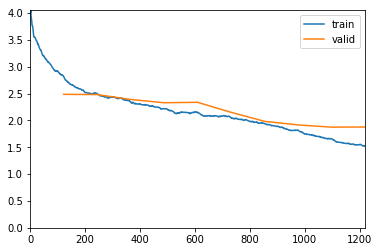

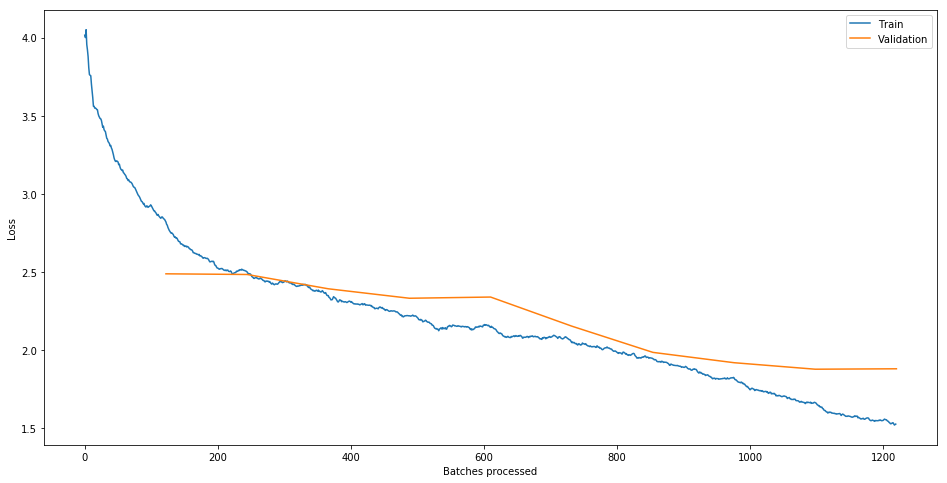

In [31]:
best_exp = "../../data/gene_images/2d_clustering/ONCO_DIM_128"
data = (ImageList.from_folder(best_exp + '/')
        .split_by_folder(train='train', valid='valid')          
        .label_from_folder()
        .databunch(bs=64)
        .normalize(imagenet_stats)
       )
arch = models.resnet101
learn = cnn_learner(data, arch, metrics=[accuracy], callback_fns=ShowGraph)
learn.fit_one_cycle(10, 0.01)
fig = learn.recorder.plot_losses(return_fig=True)
fig.set_size_inches(16, 8)

epoch,train_loss,valid_loss,accuracy,time
0,2.853556,2.631206,0.293756,00:40
1,2.505230,2.459056,0.306039,00:25
2,2.356162,2.320936,0.340839,00:25
3,2.186859,2.200295,0.361310,00:25
4,2.130601,2.263366,0.361310,00:25
5,2.044415,2.064022,0.384852,00:25
6,1.947060,2.025476,0.425793,00:25
7,1.806362,1.953799,0.436029,00:25
8,1.648043,1.924820,0.455476,00:25
9,1.513764,1.905497,0.461617,00:25


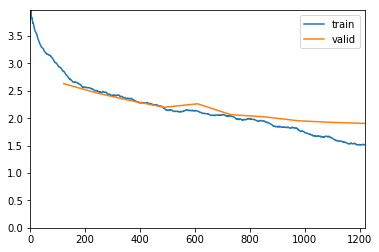

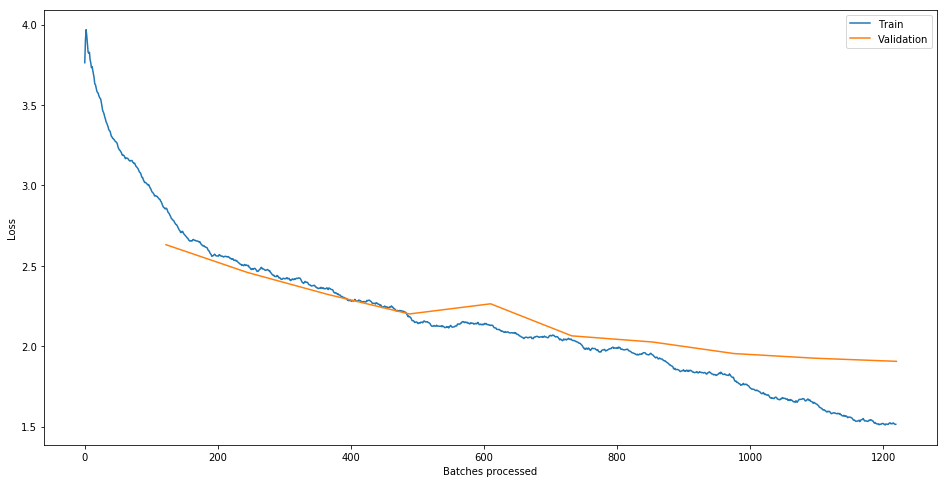

In [35]:
best_exp = "../../data/gene_images/2d_clustering/ONCO_DIM_PC50"
data = (ImageList.from_folder(best_exp + '/')
        .split_by_folder(train='train', valid='valid')          
        .label_from_folder()
        .databunch(bs=64)
        .normalize(imagenet_stats)
       )
arch = models.resnet101
learn = cnn_learner(data, arch, metrics=[accuracy], callback_fns=ShowGraph)
learn.fit_one_cycle(10, 0.01)
fig = learn.recorder.plot_losses(return_fig=True); fig.set_size_inches(16, 8)

epoch,train_loss,valid_loss,accuracy,time
0,1.450229,1.958535,0.445241,00:25
1,1.644735,2.142095,0.415558,00:25
2,1.777051,2.059652,0.420676,00:25
3,1.776957,2.067108,0.418628,00:25
4,1.733964,2.021843,0.431935,00:25
5,1.614403,2.100697,0.413511,00:25
6,1.470567,2.026004,0.458547,00:25
7,1.304066,2.064757,0.450358,00:25
8,1.135420,2.079878,0.442170,00:25
9,1.056050,2.077862,0.447288,00:25


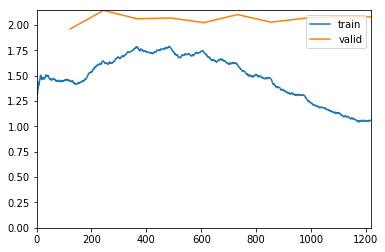

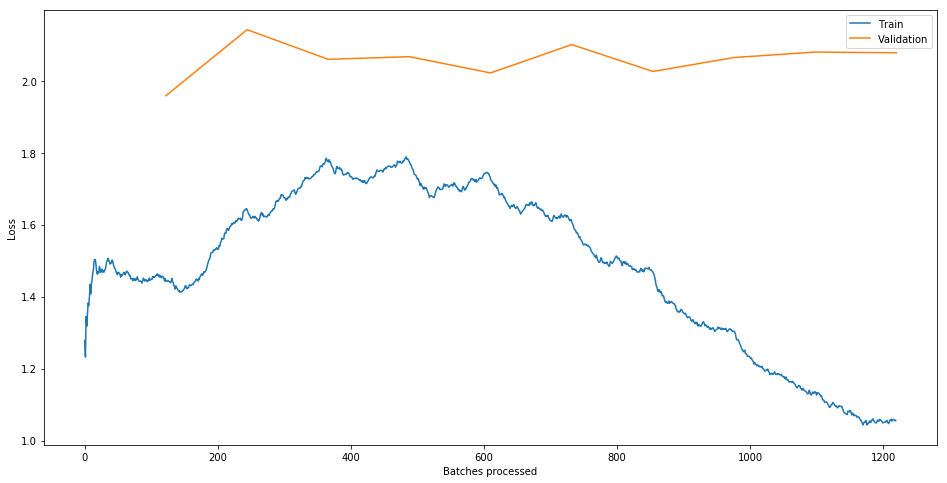

In [37]:
learn.fit_one_cycle(10, 0.005)
fig = learn.recorder.plot_losses(return_fig=True); fig.set_size_inches(16, 8)